In [1]:
import numpy as np
import dedalus.public as d3

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo

import logging
logger = logging.getLogger(__name__)

plt.style.use('/mnt/c/Ryan_Data/Python_Tool/ryan_mplstyle.mplstyle')

2024-10-28 17:31:26,937 dedalus 0/1 WARNING :: Threading has not been disabled. This may massively degrade Dedalus performance.
2024-10-28 17:31:26,939 dedalus 0/1 WARNING :: We strongly suggest setting the "OMP_NUM_THREADS" environment variable to "1".
2024-10-28 17:31:27,089 numexpr.utils 0/1 INFO :: Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-10-28 17:31:27,090 numexpr.utils 0/1 INFO :: NumExpr defaulting to 8 threads.


In [2]:
Ro = 0.3
Bu = 1

Ly_instab = 1
Ly = Ly_instab*10
Ny = 256
Lx = Ly*2
Nx = Ny*2

if_ridig = 1

In [3]:
dtype = np.float64
coords = d3.CartesianCoordinates('y')
dist = d3.Distributor(coords, dtype=dtype)
ybasis = d3.Chebyshev(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2))

In [4]:
dtype = np.float64
coords = d3.CartesianCoordinates('y')
dist = d3.Distributor(coords, dtype=dtype)
ybasis = d3.Chebyshev(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2))

dy = lambda A: d3.Differentiate(A, coords['y'])
y = dist.local_grids(ybasis); y = y[0]

# integ =  lambda A: d3.Integrate(A, ('y'))

# Fields
q1 = dist.Field(bases=ybasis )
q2 = dist.Field(bases=ybasis )

q2['g'] = -np.exp(-y**2)
q1['g'] = -q2['g']


In [5]:
# Fields
#################
P0_1 = dist.Field(name='P0_1', bases=ybasis )
P0_2 = dist.Field(name='P0_2', bases=ybasis )
tau_P0_1 = dist.Field(name='tau_P0_1')
tau_P0_1l = dist.Field(); tau_P0_1r = dist.Field()
tau_P0_2 = dist.Field(name='tau_P0_2')
tau_P0_2l = dist.Field(); tau_P0_2r = dist.Field()

#################
P1_1 = dist.Field(name='P1_1', bases=ybasis )
P1_2 = dist.Field(name='P1_2', bases=ybasis )
tau_P1_1 = dist.Field(name='tau_P1_1')
tau_P1_1l = dist.Field(); tau_P1_1r = dist.Field()
tau_P1_2 = dist.Field(name='tau_P1_2')
tau_P1_2l = dist.Field(); tau_P1_2r = dist.Field()

#################
G1_1 = dist.Field(name='G1_1', bases=ybasis )
G1_2 = dist.Field(name='G1_2', bases=ybasis )
tau_G1_1 = dist.Field(name='tau_G1_1')
tau_G1_1l = dist.Field(); tau_G1_1r = dist.Field()
tau_G1_2 = dist.Field(name='tau_G1_2')
tau_G1_2l = dist.Field(); tau_G1_2r = dist.Field()

# Substitutions
lift_basis = ybasis.derivative_basis(2)
lift = lambda A, n: d3.Lift(A, lift_basis, n)

dyy = lambda A: dy(dy(A))

avg = lambda A: d3.Average(A, 'y')
integ = lambda A: d3.Integrate(A, 'y')

q1_nomean = q1-avg(q1)
q2_nomean = q2-avg(q2)

u1 = -dy(P0_1)+Ro*(-dy(P1_1))
v1 =  Ro*(-G1_1)
u2 = -dy(P0_2)+Ro*(-dy(P1_2))
v2 =  Ro*(-G1_2)
h1 = if_ridig*P0_1-P0_2+Ro*(if_ridig*P1_1-P1_2)
h2 = P0_2-P0_1+Ro*(P1_2-P1_1)

zeta_1 = -dy(u1)
zeta_2 = -dy(u2)
div_1 = dy(v1)
div_2 = dy(v2)

In [6]:
# Problem
problem = d3.IVP([P0_1, P0_2, tau_P0_1, tau_P0_2, tau_P0_1l, tau_P0_1r, tau_P0_2l, tau_P0_2r, \
                  P1_1, P1_2, tau_P1_1, tau_P1_2, tau_P1_1l, tau_P1_1r, tau_P1_2l, tau_P1_2r, \
                  G1_1, G1_2,tau_G1_1,tau_G1_2, tau_G1_1l, tau_G1_1r, tau_G1_2l, tau_G1_2r
                    ], namespace=locals())

#################
problem.add_equation("dyy(P0_1)+(P0_2-P0_1)/Bu+tau_P0_1 +lift(tau_P0_1l,-1)+lift(tau_P0_1r,-2) =q1_nomean")
problem.add_equation("dyy(P0_2)+(P0_1-P0_2)/Bu+tau_P0_2 +lift(tau_P0_2l,-1)+lift(tau_P0_2r,-2) =q2_nomean")
problem.add_equation("integ(P0_1)=0")
problem.add_equation("integ(P0_2)=0")
problem.add_equation("dy(P0_1)(y=-Ly/2)=0"); problem.add_equation("dy(P0_1)(y=Ly/2)=0")
problem.add_equation("dy(P0_2)(y=-Ly/2)=0"); problem.add_equation("dy(P0_2)(y=Ly/2)=0")

#################
problem.add_equation("dyy(P1_1)+(P1_2-P1_1)/Bu+tau_P1_1 +lift(tau_P1_1l,-1)+lift(tau_P1_1r,-2) =-(P0_1-P0_2)**2/Bu**2+dyy(P0_1)*(P0_1-P0_2)/Bu")
problem.add_equation("dyy(P1_2)+(P1_1-P1_2)/Bu+tau_P1_2 +lift(tau_P1_2l,-1)+lift(tau_P1_2r,-2) =-(P0_2-P0_1)**2/Bu**2+dyy(P0_2)*(P0_2-P0_1)/Bu")
problem.add_equation("integ(P1_1)=0")
problem.add_equation("integ(P1_2)=0")
problem.add_equation("dy(P1_1)(y=-Ly/2)=0"); problem.add_equation("dy(P1_1)(y=Ly/2)=0")
problem.add_equation("dy(P1_2)(y=-Ly/2)=0"); problem.add_equation("dy(P1_2)(y=Ly/2)=0")

#################
problem.add_equation("dyy(G1_1)+(G1_2-G1_1)/Bu+tau_G1_1+lift(tau_G1_1l,-1)+lift(tau_G1_1r,-2)  =2*dy(P0_2-P0_1)/Bu")
problem.add_equation("dyy(G1_2)+(G1_1-G1_2)/Bu+tau_G1_2+lift(tau_G1_2l,-1)+lift(tau_G1_2r,-2)  =2*dy(P0_1-P0_2)/Bu")
problem.add_equation("integ(G1_1)=0")
problem.add_equation("integ(G1_2)=0")
problem.add_equation("G1_1(y=-Ly/2)=0"); problem.add_equation("G1_1(y=Ly/2)=0")
problem.add_equation("G1_2(y=-Ly/2)=0"); problem.add_equation("G1_2(y=Ly/2)=0")

{'LHS': interp(<Field 140644069374288>, y=5.0),
 'RHS': 0,
 'condition': 'True',
 'tensorsig': (),
 'dtype': numpy.float64,
 'M': 0,
 'L': interp(<Field 140644069374288>, y=5.0),
 'F': <Field 140644068960080>,
 'domain': <dedalus.core.domain.Domain at 0x7fea3fcb70e0>,
 'matrix_dependence': array([ True]),
 'matrix_coupling': array([ True])}

In [7]:
# Solver
solver = problem.build_solver(d3.RK222)
solver.stop_sim_time = 10

timestep = 1e-7; 
solver.step(timestep); solver.step(timestep); solver.step(timestep); solver.step(timestep); solver.step(timestep)

2024-10-28 17:31:28,248 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.1e+00/s


In [8]:
u1_e = u1.evaluate(); u1_e.change_scales(1)
u2_e = u2.evaluate(); u2_e.change_scales(1)

zeta1_e = zeta_1.evaluate(); zeta1_e.change_scales(1)
zeta2_e = zeta_2.evaluate(); zeta2_e.change_scales(1)

h1_e = h1.evaluate(); h1_e.change_scales(1)
h2_e = h2.evaluate(); h2_e.change_scales(1)
v1_e = v1.evaluate(); v1_e.change_scales(1)

div1_e = div_1.evaluate(); div1_e.change_scales(1)
div2_e = div_2.evaluate(); div2_e.change_scales(1)

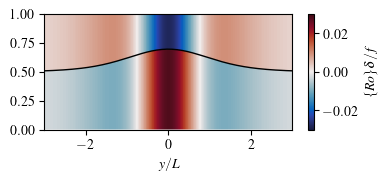

In [9]:
y1 = np.ones(h2_e['g'].size)
y2 = (h2_e['g']-h2_e['g'][0])*Ro+1/2
y3 = 0

plt.figure(figsize=(4, 1.5))
# plt.plot(y,y1)
plt.plot(y,y2,'k')

plt.ylim([0,1])
plt.xlim([-3,3])

climm = 0.03
#####################
polygon = plt.fill_between(y, y1, y2, lw=0, color='none')
xlim = (y.min(), y.max())
ylim = plt.ylim()
verts = np.vstack([p.vertices for p in polygon.get_paths()])
gradient = plt.imshow(div1_e['g'].reshape(-1, 1).T*Ro, cmap=cmo.balance, aspect='auto', origin='lower',
                      extent=[verts[:, 0].min(), verts[:, 0].max(), verts[:, 1].min(), verts[:, 1].max()], vmin=-climm,vmax=climm)
gradient.set_clip_path(polygon.get_paths()[0], transform=plt.gca().transData)

#####################
polygon = plt.fill_between(y, y2, y3, lw=0, color='none')
xlim = (y.min(), y.max())
ylim = plt.ylim()
verts = np.vstack([p.vertices for p in polygon.get_paths()])
gradient = plt.imshow(div2_e['g'].reshape(-1, 1).T*Ro, cmap=cmo.balance, aspect='auto', origin='lower',
                      extent=[verts[:, 0].min(), verts[:, 0].max(), verts[:, 1].min(), verts[:, 1].max()], vmin=-climm,vmax=climm)
gradient.set_clip_path(polygon.get_paths()[0], transform=plt.gca().transData)

cbar = plt.colorbar()
cbar.set_label(r'$\{Ro\} \delta/f$')
plt.xlabel(r"$y/L$")

figname = 'front_div'
figname = figname.replace(".", "d" ); figname = figname+'.png'
plt.savefig(figname, bbox_inches='tight', dpi=800)